https://www.kaggle.com/algord/pokemon-dcgan

# Import

In [23]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.utils import make_grid
from torch import nn, optim
from matplotlib import pyplot as plt




from IPython import display

### Us doing this project :

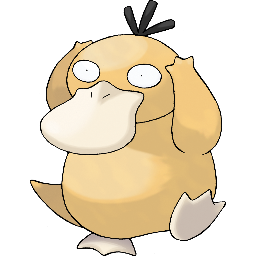

In [3]:
display.Image('data/pokemon/54.png')

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 64
image_size = 64
norm = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

In [5]:
transf = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(*norm, inplace = True),
])

In [6]:
dataset = datasets.ImageFolder(root = 'data', transform = transf)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True, num_workers = 2)

In [24]:
def unnorm(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images*stds+means

In [8]:
def show_batch(data_loader, max_images, rows):

    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize = (15, 15))
        ax.set_xticks([]); ax.set_yticks([])
        unnorm_images = unnorm(images, *norm)

        ax.imshow(make_grid(unnorm_images[:max_images], nrow = rows).permute(1, 2, 0).clamp(0, 1))

        break

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000021E9EA481F0>
Traceback (most recent call last):
  File "D:\Applications\python\lib\site-packages\torch\utils\data\dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "D:\Applications\python\lib\site-packages\torch\utils\data\dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "D:\Applications\python\lib\multiprocessing\process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "D:\Applications\python\lib\multiprocessing\popen_spawn_win32.py", line 108, in wait
    res = _winapi.WaitForSingleObject(int(self._handle), msecs)
KeyboardInterrupt: 


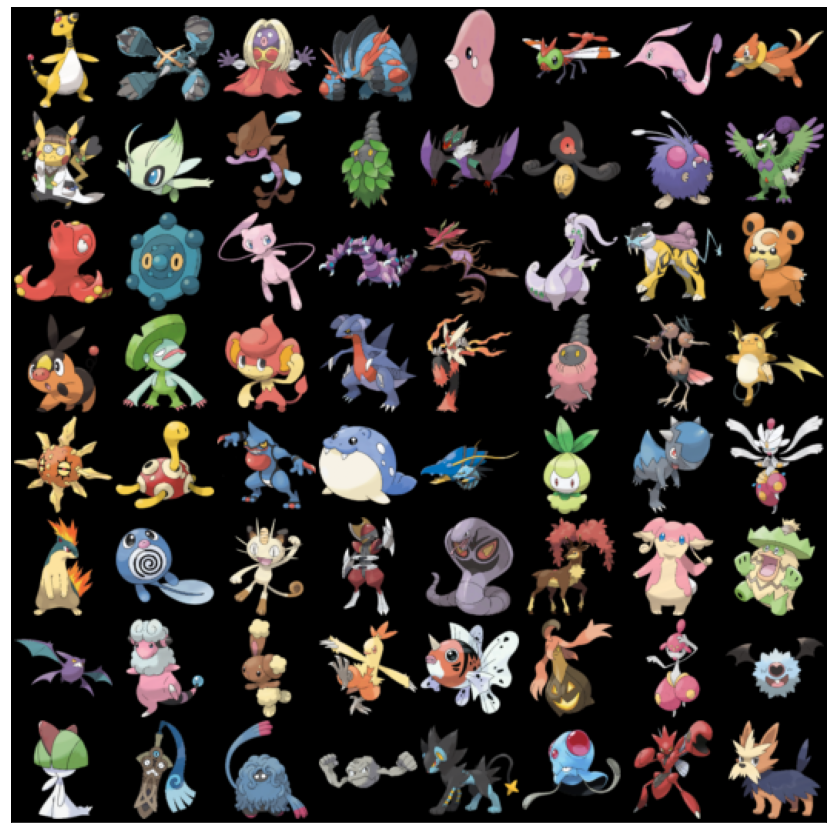

In [9]:
show_batch(dataloader, 64, 8)

In [14]:
def weights_init(m):
    classname = m.__class__.__name__

    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [15]:
class Generator(nn.Module):

    def __init__(self):

        super(Generator, self).__init__()
        
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

modelG = Generator()
modelG.to(device)
modelG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [16]:
class Discriminator(nn.Module):

    def __init__(self):

        super(Discriminator, self).__init__()
        
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    
modelD = Discriminator()
modelD.to(device)
modelD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [ ]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimizerD = optim.Adam(modelD.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizerG = optim.Adam(modelG.parameters(), lr=0.0001, betas=(0.5, 0.999))

In [ ]:
import torchvision.utils as vutils

img_list = []
G_losses, D_losses = [], []
total = 0

for epoch in range(20):
    g_loss = 0.0
    d_loss = 0.0
    D_x = 0.0
    D_G_z1 = 0.0
    D_G_z2 = 0.0
    
    for i, data in enumerate(dataloader, 0):
        
        modelD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = modelD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x += output.mean().item()
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        fake = modelG(noise)
        label.fill_(fake_label)
        output = modelD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 += output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        modelG.zero_grad()
        label.fill_(real_label)
        output = modelD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 += output.mean().item()
        optimizerG.step()
        
        g_loss += errG.item()
        d_loss += errD.item()
        total += b_size
        
    avg_g_loss = g_loss / total
    G_losses.append(avg_g_loss)
    avg_d_loss = d_loss / total
    D_losses.append(avg_d_loss)
    
    avg_D_x = D_x / len(dataloader)
    avg_D_G_z1 = D_G_z1 / len(dataloader)
    avg_D_G_z2 = D_G_z2 / len(dataloader)
    
    print('Epoch: {} \tDiscriminator Loss: {:.6f} \tGenerator Loss: {:.6f} \tD(x): {:.6f} \tD(G(z)): {:.6f} / {:.6f}'.format(
        epoch + 1,
        avg_d_loss,
        avg_g_loss,
        avg_D_x,
        avg_D_G_z1,
        avg_D_G_z2
    ))
    
    with torch.no_grad():
        fake = modelG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(unnorm(fake, *norm), padding=2, normalize=True))
    
print('Finished Training')

Epoch: 1 	Discriminator Loss: 0.009425 	Generator Loss: 0.061897 	D(x): 0.862939 	D(G(z)): 0.255987 / 0.045396
Epoch: 2 	Discriminator Loss: 0.001513 	Generator Loss: 0.043671 	D(x): 0.941909 	D(G(z)): 0.098062 / 0.006377
Epoch: 3 	Discriminator Loss: 0.000662 	Generator Loss: 0.035884 	D(x): 0.955316 	D(G(z)): 0.066780 / 0.001871
Epoch: 4 	Discriminator Loss: 0.001737 	Generator Loss: 0.043651 	D(x): 0.900045 	D(G(z)): 0.136357 / 0.001636
Epoch: 5 	Discriminator Loss: 0.001334 	Generator Loss: 0.036283 	D(x): 0.898203 	D(G(z)): 0.164988 / 0.001355
Epoch: 6 	Discriminator Loss: 0.000701 	Generator Loss: 0.028932 	D(x): 0.904081 	D(G(z)): 0.092152 / 0.001707
Epoch: 7 	Discriminator Loss: 0.000515 	Generator Loss: 0.028027 	D(x): 0.954388 	D(G(z)): 0.107179 / 0.001092
Epoch: 8 	Discriminator Loss: 0.000353 	Generator Loss: 0.021136 	D(x): 0.931176 	D(G(z)): 0.055427 / 0.001272
Epoch: 9 	Discriminator Loss: 0.000758 	Generator Loss: 0.021580 	D(x): 0.878567 	D(G(z)): 0.130257 / 0.001219
E

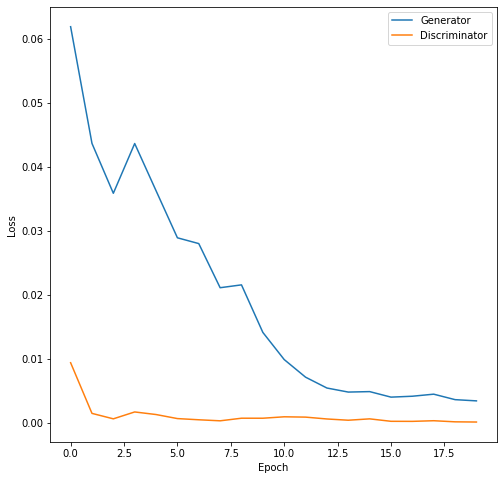

In [ ]:
plt.figure(figsize = (8, 8))
plt.plot(G_losses,label="Generator")
plt.plot(D_losses,label="Discriminator")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

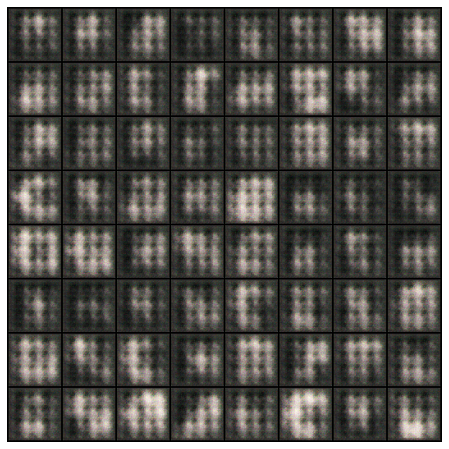

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list[::15]]
ani = animation.ArtistAnimation(fig, ims, interval=250, repeat_delay=250, blit=True)

HTML(ani.to_jshtml())

In [ ]:
torch.save(modelG.state_dict(), 'Generator.pth')
torch.save(modelD.state_dict(), 'Discriminator.pth')

In [20]:
model_load_G = Generator()
model_load_G.load_state_dict(torch.load('Generator.pth'))
model_load_G.eval()

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [ ]:
model_load_D = Discriminator()
model_load_D.load_state_dict(torch.load('Discriminator.pth'))
model_load_D.eval()

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [26]:
fixed_noise = torch.randn(64, 100, 1, 1, device='cpu')
real_label = 1.
fake_label = 0.
images = []

for i in range(3):
    with torch.no_grad():
        fake = model_load_G(fixed_noise).detach().cpu()
    images.append(torchvision.utils.make_grid(unnorm(fake, *norm), padding=2, normalize=True))

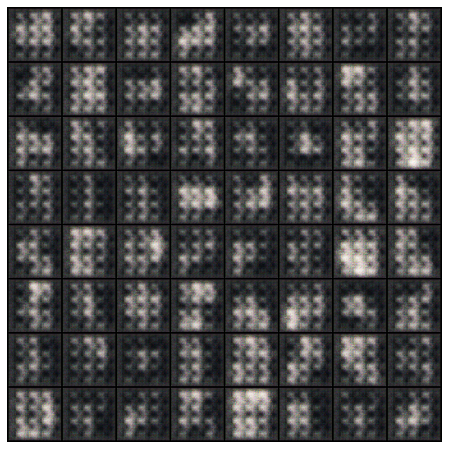

In [28]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in images[::15]]